In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/collections2.zip

In [ ]:
!find . -name '.DS_Store' -type f -delete

In [ ]:
import pandas as pd
import os
import numpy as np

import os
import matplotlib.pyplot as plt
import skimage
import re
import numpy as np
import cv2
from skimage import io
from IPython.display import clear_output

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
import torch
import torchvision
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

In [ ]:
whole = pd.read_csv("/content/drive/MyDrive/whole_dataset.csv", index_col=0)
whole['full_name'] = whole['collection']+'/'+whole['name']
whole = whole.sort_values(by=['collection', 'name'])

In [ ]:
for x in ['price']:
    q75,q25 = np.percentile(whole.loc[:,x],[75,25])
    intr_qr = q75-q25
 
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
 
    whole.loc[whole[x] < min,x] = np.nan
    whole.loc[whole[x] > max,x] = np.nan

In [ ]:
whole.isnull().sum()

name              0
price         10317
collection        0
label             0
full_name         0
dtype: int64

In [ ]:
whole.dropna(inplace=True)

In [ ]:
whole.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,price,label
count,88770,88770
mean,9241.47,1.76696
std,11572.7,1.30902
min,1,0
25%,1224,1
50%,4049,2
75%,13000,3
max,48340,4


In [ ]:
whole['price_quartile'] = (
    pd.qcut(whole['price'], 4, labels=[0, 1, 2, 3])
)

In [ ]:
whole.drop(columns=['label'], inplace=True)

In [ ]:
new_df = whole
new_df

,name,price,collection,full_name,price_quartile
3048,Akuma #3050,3655.0,akumaorigins,akumaorigins/Akuma #3050,1
3939,Bone Slayer #3940,2772.0,akumaorigins,akumaorigins/Bone Slayer #3940,1
577,Dovah Priest #579,1761.0,akumaorigins,akumaorigins/Dovah Priest #579,1
1711,Ghost of the Realm #1707,2390.0,akumaorigins,akumaorigins/Ghost of the Realm #1707,1
50,Hakuma #42,3406.0,akumaorigins,akumaorigins/Hakuma #42,1
...,...,...,...,...,...
9971,VaynerSports Pass #9982,2296.0,vaynersports-pass-vsp,vaynersports-pass-vsp/VaynerSports Pass #9982,1
9996,VaynerSports Pass #9983,2296.0,vaynersports-pass-vsp,vaynersports-pass-vsp/VaynerSports Pass #9983,1
9925,VaynerSports Pass #9984,1408.0,vaynersports-pass-vsp,vaynersports-pass-vsp/VaynerSports Pass #9984,1
1023,VaynerSports Pass #999,1874.0,vaynersports-pass-vsp,vaynersports-pass-vsp/VaynerSports Pass #999,1


In [ ]:
image_names = []
for dir in os.listdir("collections"):
    for file in os.listdir("collections/" + dir):
        filename = os.fsdecode(file)
        image_names.append(dir+"/"+os.path.splitext(filename)[0])

In [ ]:
image_names_set = set(image_names)
df_names_set = set(df.full_name.apply(lambda x: str(x)).values)

In [ ]:
difference = image_names_set - df_names_set
difference

In [ ]:
for elem in difference:
      try:
          os.remove(f'collections/{elem}.png')
      except:
          os.remove(f'collections/{elem}.jpeg')

In [ ]:
def read_files(collections):
    # i = 0
    X = []
    for coll in sorted(os.listdir(collections)):
        files = sorted(os.listdir(f"/content/collections/{coll}"))
        for name in files:
            img = cv2.imread(f"/content/collections/{coll}" + '/' + name)
            img = cv2.resize(img, (126, 126))
            X.append(img)
    return X

In [ ]:
X = read_files("/content/collections")

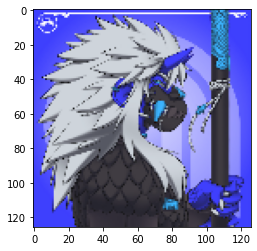

In [ ]:
image = skimage.img_as_ubyte(X[0])
plt.imshow(image)

In [ ]:
Y = new_df.price.values

In [ ]:
class NftDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.X = x
        self.Y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        img = skimage.img_as_ubyte(self.X[index])
        if self.transform:
            img = self.transform(img)
        return img, self.Y[index]

In [ ]:
transform_img = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Resize((224,224))
])

In [ ]:
dataset = NftDataset(X, Y, transform_img)
train_set, test_set = torch.utils.data.random_split(dataset, [round(0.7*len(dataset)), round(0.3*len(dataset))])

train_loader = DataLoader(dataset=train_set, batch_size=128, drop_last=True, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=128, shuffle=True)

In [ ]:
for x, y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([128, 3, 224, 224]) torch.Size([128])


In [ ]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(512, 4)
_ = model.cuda()

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
lr = 1e-4
optimizer = optim.Adam(model.parameters(), lr)
num_epochs = 10

In [ ]:
train_losses = []
val_losses = []

train_metrics = []
val_metrics = []

hist = {"train_loss": [],
        "train_accuracy": [],
        "test_loss": [],
        "test_accuracy": []}

Epoch 9/10	 Loss mean: 0.411516	 Accuracy mean: 0.814610
Epoch 9/10	 Val Loss mean: 1.268091	 Test Accuracy mean: 0.607762


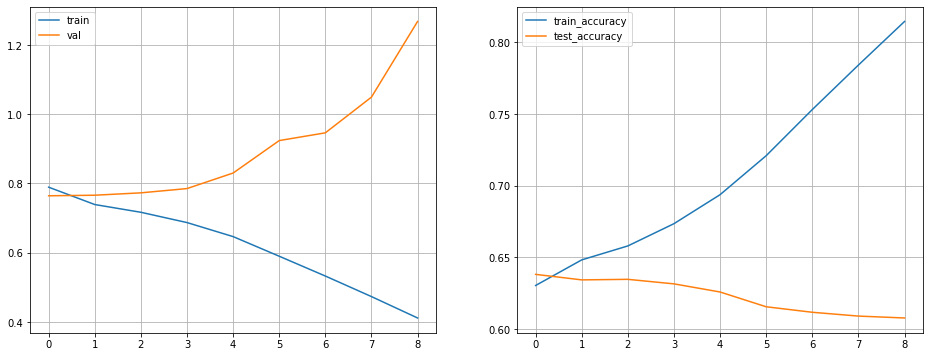

Epoch: 10 	Loss: 0.298951
Epoch: 10 	Loss: 0.320674
Epoch: 10 	Loss: 0.367750
Epoch: 10 	Loss: 0.223981
Epoch: 10 	Loss: 0.254461
Epoch: 10 	Loss: 0.343313
Epoch: 10 	Loss: 0.228404
Epoch: 10 	Loss: 0.349992
Epoch: 10 	Loss: 0.369455
Epoch: 10 	Loss: 0.385830
Epoch: 10 	Loss: 0.313661
Epoch: 10 	Loss: 0.330874
Epoch: 10 	Loss: 0.469288
Epoch: 10 	Loss: 0.319773
Epoch: 10 	Loss: 0.369372
Epoch: 10 	Loss: 0.364947
Epoch: 10 	Loss: 0.363988
Epoch: 10 	Loss: 0.359481
Epoch: 10 	Loss: 0.300211
Epoch: 10 	Loss: 0.407200
Epoch: 10 	Loss: 0.351437
Epoch: 10 	Loss: 0.427893
Epoch: 10 	Loss: 0.433723
Epoch: 10 	Loss: 0.354012
Epoch: 10 	Loss: 0.349227
Epoch: 10 	Loss: 0.336389
Epoch: 10 	Loss: 0.478255
Epoch: 10 	Loss: 0.384186
Epoch: 10 	Loss: 0.408260
Epoch: 10 	Loss: 0.313320
Epoch: 10 	Loss: 0.390031
Epoch: 10 	Loss: 0.397820
Epoch: 10 	Loss: 0.438120
Epoch: 10 	Loss: 0.412573
Epoch: 10 	Loss: 0.401727
Epoch: 10 	Loss: 0.332981
Epoch: 10 	Loss: 0.325165
Epoch: 10 	Loss: 0.493892
Epoch: 10 	L

In [ ]:
for i in range(num_epochs):
    if i > 0:
        print("Epoch %d/%d\t Loss mean: %f\t Accuracy mean: %f"% \
                (i, num_epochs, epoch_loss, epoch_accuracy))
        print("Epoch %d/%d\t Val Loss mean: %f\t Test Accuracy mean: %f"% \
            (i, num_epochs, test_loss, test_accuracy))

        plt.figure(figsize=(16, 6))
        plt.subplot(121)
        plt.plot(hist['train_loss'], label='train')
        plt.plot(hist['test_loss'], label='val')
        plt.legend()
        plt.grid()

        plt.subplot(122)
        plt.plot(hist['train_accuracy'], label='train_accuracy')
        plt.plot(hist['test_accuracy'], label='test_accuracy')
        plt.legend()
        plt.grid()
        plt.show()


    epoch_losses = []
    test_losses = []
    epoch_accuracies = []
    test_accuracies = []

    model.train()
    for k, (X, Y) in enumerate(train_loader):
        optimizer.zero_grad()
        y_pred = model(X.cuda())
        loss = criterion(y_pred, Y.cuda())
        accuracy = (torch.argmax(y_pred.detach().cpu(), 1) == Y.cpu()).sum()/len(Y)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accuracies.append(accuracy)
        if k%10 == 0:
            print("Epoch: %d \tLoss: %f"%(i+1, loss.item()))

    epoch_loss = np.mean(np.array(epoch_losses))
    epoch_accuracy = np.mean(np.array(epoch_accuracies))
    hist['train_accuracy'].append(epoch_accuracy)
    hist['train_loss'].append(epoch_loss)

    with torch.no_grad():
        model.eval()
        for k, (X, Y) in enumerate(test_loader):
            y_pred = model(X.cuda())
            loss = criterion(y_pred, Y.cuda())
            accuracy = (torch.argmax(y_pred.detach().cpu(), 1) == Y.cpu()).sum()/len(Y)
            test_losses.append(loss.item())
            test_accuracies.append(accuracy)

    test_loss = np.mean(np.array(test_losses))
    test_accuracy = np.mean(np.array(test_accuracies))
    hist['test_loss'].append(test_loss)
    hist['test_accuracy'].append(test_accuracy)
    
    if i < (num_epochs - 1):
        clear_output()

#Feature extraction

In [ ]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x


model = models.resnet18(pretrained=True)
model.fc = Identity()
example = torch.randn(1, 3, 224, 224)
output = model(example)
print(output.shape)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

torch.Size([1, 512])


In [ ]:
loader = DataLoader(dataset=dataset)

In [ ]:
visual_features = pd.DataFrame()

In [ ]:
data = []
with torch.no_grad():
    for k, (X, Y) in enumerate(loader):
        output = model(X).numpy()
        data.append(output)
        print(k)

In [ ]:
data[0].shape

(1, 512)

In [ ]:
data_mod = []
for arr in data:
    data_mod.append(arr[0])

In [ ]:
features = pd.DataFrame(data=data_mod)
features

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0.934029,0.981545,0.976412,1.066683,0.968872,0.891119,0.988836,1.178757,0.913636,0.938815,...,0.984249,0.928865,0.911456,0.925369,1.151510,0.984131,0.951318,0.932598,0.990700,0.942260
1,0.938220,0.880504,0.857132,1.040995,0.976252,0.925164,0.967621,1.140278,0.949873,0.951100,...,1.033237,0.888906,0.921547,0.746365,1.204340,0.977105,1.019365,0.972921,0.971863,0.997996
2,0.895706,0.929837,0.961717,1.014144,0.871044,0.842708,0.989983,1.211613,0.964185,0.978369,...,0.897442,0.879061,0.936334,0.873518,1.043786,0.989539,0.955227,0.892811,1.079472,0.936167
3,0.951730,0.979985,0.920574,1.117102,0.889481,0.952616,0.966989,1.156702,0.941262,0.967308,...,0.943299,0.963741,0.848848,0.896376,1.168763,0.981159,0.950871,0.976202,0.885704,0.993610
4,0.868721,0.996198,0.935798,1.045763,0.883948,0.818028,0.979869,1.130943,0.919120,0.921112,...,0.993533,0.915709,0.876882,0.864123,1.104043,1.049291,0.926737,0.923398,1.095547,1.002458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19996,0.914120,0.925273,0.900118,0.960528,0.967286,0.891464,0.888590,1.154843,0.897539,0.993960,...,0.945114,0.836829,0.879486,0.859434,1.121233,0.965460,0.974839,0.898467,1.064630,1.005797
19997,0.914842,0.856208,0.940224,1.083822,0.977326,0.854397,0.955765,1.127757,1.005424,0.989290,...,0.961555,0.860696,0.872420,0.902367,1.170768,0.942389,0.942617,0.834145,1.074168,0.990893
19998,0.881455,0.935094,0.942270,1.035600,1.003365,0.920872,0.952930,1.151631,0.863433,0.939638,...,0.898297,0.893952,0.913888,0.906701,1.157844,0.976933,0.979193,0.903136,1.060011,1.003754
19999,0.810684,0.861484,0.919543,1.076376,0.964247,0.943317,0.912372,1.134955,0.858544,0.961412,...,0.929174,0.924310,0.849455,0.898823,1.015505,1.030162,0.995825,0.963040,1.102519,1.015715


In [ ]:
import pandas
from sklearn.decomposition import PCA
import numpy
import matplotlib.pyplot as plot

In [ ]:
df = features
df_normalized=(df - df.mean()) / df.std()

pca = PCA(n_components = 0.8)
pca.fit(df_normalized)

# Reformat and view results
# loadings = pandas.DataFrame(pca.components_.T,
# columns=['PC%s' % _ for _ in range(len(df_normalized.columns))],
# index=df.columns)
# print(loadings)

# plot.plot(pca.explained_variance_ratio_)
# plot.ylabel('Explained Variance')
# plot.xlabel('Components')
# plot.show()

PCA(n_components=0.8)

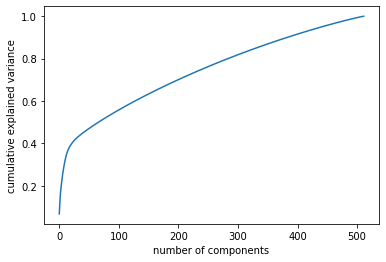

In [ ]:
pca = PCA().fit(df_normalized)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [ ]:
reduced = pca.transform(df_normalized)

In [ ]:
reduced_df = pd.DataFrame(data=reduced)
reduced_df

,0,1,2,3,4,5,6,7,8,9,...,274,275,276,277,278,279,280,281,282,283
0,-3.937315,-2.567531,-1.376602,-0.813760,-0.790100,0.916467,1.483279,1.122138,-1.087391,1.164580,...,-0.599950,0.609310,-0.901150,-0.628192,0.855657,-0.711888,-2.027327,0.701824,-0.400339,0.318574
1,-1.815528,-0.932137,0.595863,-1.598759,0.910720,0.820447,1.265124,-0.729233,-0.997868,-0.434817,...,-2.054521,-0.074171,-0.883354,-1.198534,-1.662925,-0.837245,1.641132,0.314230,0.637206,1.397718
2,-2.859916,-0.769960,0.582185,-0.502405,0.503618,0.757827,-0.845083,0.422818,0.348705,-0.161861,...,-0.760554,-0.903880,-0.011446,0.775908,1.150895,1.345585,-0.665230,-0.181188,-0.155098,-2.496632
3,-4.178899,-0.947058,-0.440886,1.740638,0.757726,0.208345,-0.311448,0.155369,-0.793174,2.948411,...,-0.200347,-0.724900,0.547996,-0.777224,-1.327320,0.012508,-1.055311,-0.843231,-0.340563,2.137059
4,-1.280041,-0.603272,-0.004094,0.410148,-0.641354,0.544547,0.100590,-0.461699,-2.788387,-0.766481,...,-0.182125,-0.685565,1.069598,1.021115,0.461143,-0.311325,-0.914192,-0.241715,0.858423,-0.624972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19996,-3.204887,-0.492565,0.297809,0.340203,0.164783,0.420414,0.740324,-1.239995,0.535843,2.433091,...,0.795038,0.445149,0.343294,0.748924,0.392942,1.363627,0.350984,0.066128,-0.218977,-1.624233
19997,-3.769390,-1.197640,-0.760727,-0.650794,-0.973760,2.079770,2.638554,-0.966320,1.029263,1.144996,...,0.037003,1.675251,0.067668,-1.452564,-1.350467,0.697491,-2.213270,1.170563,0.151289,0.472465
19998,-3.345592,-1.012170,-0.166564,-2.994272,-0.832758,0.191588,1.060784,-2.524555,0.735302,0.377010,...,-0.174888,-0.070872,0.775019,0.651244,1.023454,-0.953282,-0.128287,0.193186,2.099055,-1.336136
19999,-2.922024,-0.235143,-0.719404,0.515331,2.634371,0.659513,2.951838,-1.127043,-0.188093,1.727797,...,0.070581,0.122328,-0.175168,0.555723,0.226966,1.864319,0.549531,-0.682646,0.347119,-0.884057


#KNN

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
%matplotlib inline

In [ ]:
y = Y[:20001]

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(reduced, y,train_size=0.7)

In [ ]:
fig,ax=plt.subplots(figsize=(10,10))
k_list=np.arange(1,80,1)
knn_dict={}
for i in k_list:
    knn=KNeighborsRegressor(n_neighbors=int(i))
    model_knn=knn.fit(x_train,y_train)
    y_knn_pred=model_knn.predict(x_test)
    mse=mean_squared_error(y_test,y_knn_pred)
    knn_dict[i]=mse
ax.plot(knn_dict.keys(),knn_dict.values())
ax.set_xlabel('K-VALUE', fontsize=20)
ax.set_ylabel('MSE' ,fontsize=20)
ax.set_title('ELBOW PLOT' ,fontsize=28)

In [ ]:
knn=KNeighborsRegressor(n_neighbors=int(np.sqrt(20000)))
model_knn=knn.fit(x_train,y_train)
y_knn_pred=model_knn.predict(x_test)
mse=mean_squared_error(y_test,y_knn_pred)

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
mean_absolute_percentage_error(y_test, y_knn_pred)

88.98419523127762

#Gradient Boosting

In [4]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_percentage_error

In [3]:
model = GradientBoostingRegressor()
grid = dict()
grid['n_estimators'] = [10, 50, 100]
grid['learning_rate'] = [0.0001, 0.001, 0.01]
grid['subsample'] = [0.5, 0.7, 1.0]
grid['max_depth'] = [3, 7, 9]

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring=mean_absolute_percentage_error)
grid_result = grid_search.fit(reduced, y)

In [5]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 93.33334 using {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.7}


##Random Forest

In [6]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error

In [7]:
model = RandomForestRegressor()
grid = dict()
grid['n_estimators'] = [10, 50, 100]
grid['max_features'] = [1, 3, 7]
grid['max_samples'] = [0.1, 0.5, 1.0]
grid['max_depth'] = [1, 3, 7]

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring=mean_absolute_percentage_error)
grid_result = grid_search.fit(reduced, y)

In [11]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 110.00021 using {'n_estimators: 100, 'max_features': 3, 'max_samples': 1.0, 'max_depth': 7}
